In [1]:
from tinygrad.tensor import Tensor
from temp.print_tree import print_tree
from tinygrad.nn.optim import Adam, LAMB

In [2]:
import functools
import itertools

In [3]:
from tinygrad.helpers import dtypes
from tinygrad.ops import Device

Device.DEFAULT = 'TORCH'

# data

In [4]:
import pathlib
import json
import  numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile

In [5]:
BASEDIR = pathlib.Path("../../../extra/datasets/librispeech")

In [6]:
with open(BASEDIR / "dev-clean-wav.json") as f:
  ci = json.load(f)

In [7]:
FILTER_BANK = np.expand_dims(librosa.filters.mel(sr=16000, n_fft=512, n_mels=80, fmin=0, fmax=8000), 0)
WINDOW = librosa.filters.get_window("hann", 320)

In [8]:

def feature_extract(x, x_lens):
  x_lens = np.ceil((x_lens / 160) / 3).astype(np.int32)

  # pre-emphasis
  x = np.concatenate((np.expand_dims(x[:, 0], 1), x[:, 1:] - 0.97 * x[:, :-1]), axis=1)

  # stft
  x = librosa.stft(x, n_fft=512, window=WINDOW, hop_length=160, win_length=320, center=True, pad_mode="reflect")
  x = np.stack((x.real, x.imag), axis=-1)

  # power spectrum
  x = (x**2).sum(-1)

  # mel filter bank
  x = np.matmul(FILTER_BANK, x)

  # log
  x = np.log(x + 1e-20)

  # feature splice
  seq = [x]
  for i in range(1, 3):
    tmp = np.zeros_like(x)
    tmp[:, :, :-i] = x[:, :, i:]
    seq.append(tmp)
  features = np.concatenate(seq, axis=1)[:, :, ::3]

  # normalize
  features_mean = np.zeros((features.shape[0], features.shape[1]), dtype=np.float32)
  features_std = np.zeros((features.shape[0], features.shape[1]), dtype=np.float32)
  for i in range(features.shape[0]):
    features_mean[i, :] = features[i, :, :x_lens[i]].mean(axis=1)
    features_std[i, :] = features[i, :, :x_lens[i]].std(axis=1, ddof=1)
  features_std += 1e-5
  features = (features - np.expand_dims(features_mean, 2)) / np.expand_dims(features_std, 2)

  return features.transpose(2, 0, 1), x_lens.astype(np.float32)

In [9]:
def load_wav(file):
  sample = soundfile.read(file)[0].astype(np.float32)
  return sample, sample.shape[0]

In [10]:
def iterate(bs=1, start=0):
  print(f"there are {len(ci)} samples in the dataset")
  for i in range(start, len(ci), bs):
    samples, sample_lens = zip(*[load_wav(BASEDIR / v["files"][0]["fname"]) for v in ci[i : i + bs]])
    samples = list(samples)
    # pad to same length
    max_len = max(sample_lens)
    for j in range(len(samples)):
      samples[j] = np.pad(samples[j], (0, max_len - sample_lens[j]), "constant")
    samples, sample_lens = np.array(samples), np.array(sample_lens)

    yield feature_extract(samples, sample_lens), np.array([v["transcript"] for v in ci[i : i + bs]])

In [11]:
X, Y = next(iterate())
print(X[0].shape, Y.shape)

there are 2703 samples in the dataset
(220, 1, 240) (1,)


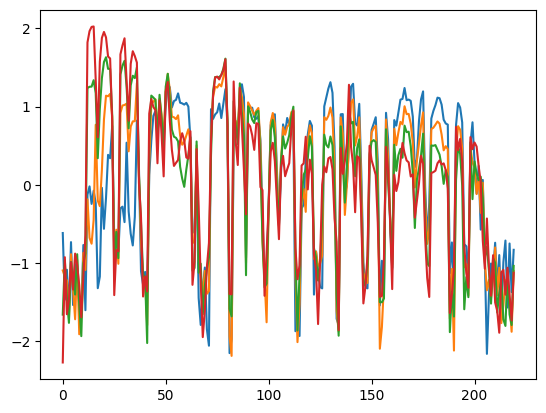

In [12]:
_=plt.plot(X[0][:,0,2:6])

## tokenize

In [13]:
import numpy as np
from tinygrad.tensor import Tensor

In [14]:
characters = [*" 'abcdefghijklmnopqrstuvwxtz","<skip>"]
c2i= dict([(c,i) for i,c in enumerate(characters)])
charn = len(characters)

def text_encode(text:list[str]):
    if isinstance(text,str):text = [text]
    return [[np.array(c2i[char]) for char in seq] for seq in text]

def text_decode(toks:Tensor):
    ret = []
    for seq in toks:
        ret.append("".join([characters[int(tok)] for tok in seq ]))
    return ret


assert text_decode(text_encode(Y)) == Y

In [15]:
labels = text_encode(Y[0])[0]

# model

In [16]:
# from models.rnnt import RNNT, LSTM, LSTMCell, StackTime,Encoder, Prediction, Joint
from tinygrad.jit import TinyJit
from tinygrad.nn import Embedding, Linear

In [32]:
class RNNT:
  def __init__(self, input_features=240, vocab_size=29, enc_hidden_size=1024, pred_hidden_size=320, joint_hidden_size=512, pre_enc_layers=2, post_enc_layers=3, pred_layers=2, stack_time_factor=2, dropout=0.32):
    self.encoder = Encoder(input_features, enc_hidden_size, pre_enc_layers, post_enc_layers, stack_time_factor, dropout)
    self.prediction = Prediction(vocab_size, pred_hidden_size, pred_layers, dropout)
    self.joint = Joint(vocab_size, pred_hidden_size, enc_hidden_size, joint_hidden_size, dropout)
    self.params = [*self.encoder.params, *self.prediction.params, *self.joint.params]

  def decode(self, x, x_lens, max_output = 1e9):
    logits, logit_lens = self.encoder(x, x_lens)
    outputs = []
    for b in range(logits.shape[0]):
      inseq = logits[b, :, :].unsqueeze(1)
      logit_len = logit_lens[b]
      seq = self._greedy_decode(inseq, int(np.ceil(logit_len.numpy()).item()),max_output)
      outputs.append(seq)
    return outputs

  def _greedy_decode(self, logits, logit_len,max_output):
    hc = Tensor.zeros(self.prediction.rnn.layers, 2, self.prediction.hidden_size, requires_grad=False)
    labels = []
    label = Tensor.zeros(1, 1, requires_grad=False)
    mask = Tensor.zeros(1, requires_grad=False)
    for time_idx in range(logit_len):
      logit = logits[time_idx, :, :].unsqueeze(0)
      not_blank = True
      added = 0
      while not_blank and added < 30:
        if len(labels) > 0:
          mask = (mask + 1).clip(0, 1)
          label = Tensor([[labels[-1] if labels[-1] <= 28 else labels[-1] - 1]], requires_grad=False) + 1 - 1
        jhc = self._pred_joint(Tensor(logit.numpy()), label, hc, mask)
        k = jhc[0, 0, :29].argmax(axis=0).numpy()
        not_blank = k != 28
        if not_blank:
          labels.append(k)
          hc = jhc[:, :, 29:] + 1 - 1
        added += 1
    return labels

  # @TinyJit
  def _pred_joint(self, logit, label, hc, mask):
    g, hc = self.prediction(label, hc, mask)
    j = self.joint(logit, g)[0]
    j = j.pad(((0, 1), (0, 1), (0, 0)))
    out = j.cat(hc, dim=2)
    return out.realize()
  

class LSTMCell:
  def __init__(self, input_size, hidden_size, dropout):
    self.dropout = dropout

    self.weights_ih = Tensor.uniform(hidden_size * 4, input_size)
    self.bias_ih = Tensor.uniform(hidden_size * 4)
    self.weights_hh = Tensor.uniform(hidden_size * 4, hidden_size)
    self.bias_hh = Tensor.uniform(hidden_size * 4)

  def __call__(self, x, hc):
    gates = x.linear(self.weights_ih.T, self.bias_ih) + hc[:x.shape[0]].linear(self.weights_hh.T, self.bias_hh)

    i, f, g, o = gates.chunk(4, 1)
    i, f, g, o = i.sigmoid(), f.sigmoid(), g.tanh(), o.sigmoid()

    c = (f * hc[x.shape[0]:]) + (i * g)
    h = (o * c.tanh()).dropout(self.dropout)

    return Tensor.cat(h, c).realize()

class LSTM:
  def __init__(self, input_size, hidden_size, layers, dropout):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.layers = layers

    self.cells = [LSTMCell(input_size if i == 0 else hidden_size, hidden_size, dropout if i != layers - 1 else 0) for i in range(layers)]

    self.params = list(itertools.chain(*[[cell.bias_hh,cell.bias_ih,cell.weights_hh,cell.weights_ih] for cell in self.cells]))

  def __call__(self, x, hc):
    @TinyJit
    def _do_step(x_, hc_):
      return self.do_step(x_, hc_)

    if hc is None:
      hc = Tensor.zeros(self.layers, 2 * x.shape[1], self.hidden_size, requires_grad=False)

    output = None
    for t in range(x.shape[0]):
      hc = _do_step(x[t] + 1 - 1, hc) # TODO: why do we need to do this?
      if output is None:
        output = hc[-1:, :x.shape[1]]
      else:
        output = output.cat(hc[-1:, :x.shape[1]], dim=0).realize()

    return output, hc

  def do_step(self, x, hc):
    new_hc = [x]
    for i, cell in enumerate(self.cells):
      new_hc.append(cell(new_hc[i][:x.shape[0]], hc[i]))
    return Tensor.stack(new_hc[1:]).realize()

class Joint:
  def __init__(self, vocab_size, pred_hidden_size, enc_hidden_size, joint_hidden_size, dropout):
    self.dropout = dropout
    self.l1 = Linear(pred_hidden_size + enc_hidden_size, joint_hidden_size)
    self.l2 = Linear(joint_hidden_size, vocab_size)
    self.params = [self.l1.bias, self.l1.weight, self.l2.bias, self.l2.weight]

  def __call__(self, f, g):
    (_, T, H), (B, U, H2) = f.shape, g.shape
    f = f.unsqueeze(2).expand(B, T, U, H)
    g = g.unsqueeze(1).expand(B, T, U, H2)

    inp = f.cat(g, dim=3)
    t = self.l1(inp).relu()
    t = t.dropout(self.dropout)
    return self.l2(t)

class Encoder:
  def __init__(self, input_size, hidden_size, pre_layers, post_layers, stack_time_factor, dropout):
    self.pre_rnn = LSTM(input_size, hidden_size, pre_layers, dropout)
    self.stack_time = StackTime(stack_time_factor)
    self.post_rnn = LSTM(stack_time_factor * hidden_size, hidden_size, post_layers, dropout)
    self.params = [*self.pre_rnn.params, *self.post_rnn.params]

  def __call__(self, x, x_lens):
    x, _ = self.pre_rnn(x, None)
    x, x_lens = self.stack_time(x, x_lens)
    x, _ = self.post_rnn(x, None)
    return x.transpose(0, 1), x_lens
  
class StackTime:
  def __init__(self, factor):
    self.factor = factor

  def __call__(self, x, x_lens):
    x = x.pad(((0, (-x.shape[0]) % self.factor), (0, 0), (0, 0)))
    x = x.reshape(x.shape[0] // self.factor, x.shape[1], x.shape[2] * self.factor)
    return x, x_lens / self.factor if x_lens is not None else None

class Prediction:
  def __init__(self, vocab_size, hidden_size, layers, dropout):
    self.hidden_size = hidden_size

    self.emb = Embedding(vocab_size - 1, hidden_size)
    self.rnn = LSTM(hidden_size, hidden_size, layers, dropout)

    self.params = [self.emb.weight,*self.rnn.params]

  def __call__(self, x, hc, m):
    emb = self.emb(x) * m
    x_, hc = self.rnn(emb.transpose(0, 1), hc)
    return x_.transpose(0, 1), hc
  
rnnt = RNNT()

# training

In [47]:
opt = Adam(rnnt.params[8:])
enc, enc_lens  = rnnt.encoder(Tensor(X[0]),Tensor(X[1]))
preds = None
hc = Tensor.zeros(rnnt.prediction.rnn.layers, 2, rnnt.prediction.hidden_size)
for x in [0] + labels:
    pred,hc = rnnt.prediction.__call__(Tensor([[x]]),hc,1)
    preds = pred if preds is None else preds.cat(pred,dim=1).realize()

In [48]:

distribution_tensor = rnnt.joint.__call__(preds, enc).softmax(3).realize()
distribution = distribution_tensor.numpy()

In [20]:
def calc_loss():
    T,U = distribution.shape[2],distribution.shape[1]
    assert len(labels) == U-1
    assert enc.shape[1] == T

    alpha = np.zeros((T,U))
    alpha[0,0] = 1.

    for t in range(T):
        for u in range(U):
            if t < T-1: 
                alpha[t+1,u] = alpha[t,u] * distribution[0,u,t,-1]
            if u < U-1: 
                label = int((labels)[u])
                alpha[t,u+1] += alpha[t,u] * distribution[0,u,t,label]

    P = alpha[-1,-1] * distribution[0,-1,-1,-1]
    Loss = -np.log(P)
    Loss_grad = 1

    alpha_grad = np.zeros((T,U))
    alpha_grad[-1,-1] = -1/alpha[-1,-1]
    distribution_grad = np.zeros_like(distribution,dtype=np.float64)
    distribution_grad[0,-1,-1,-1] = -1/distribution[0,-1,-1,-1]

    for t in reversed(range(T)):
        for u in reversed(range(U)):
            if t < T-1:
                alpha_grad[t,u] += alpha_grad[t+1,u] * distribution[0,u,t,-1]
                distribution_grad[0,u,t,-1] += alpha_grad[t+1,u] * alpha[t,u]
            if u < U-1:
                label = int((labels)[u])

                alpha_grad[t,u] += alpha_grad[t,u+1] * distribution[0,u,t,label]
                distribution_grad[0,u,t,label] += alpha_grad[t,u+1] * alpha[t,u]

    plt.imshow(-distribution_grad[0,:,:,:].sum(-1))
    plt.show()
    return Loss,distribution_grad

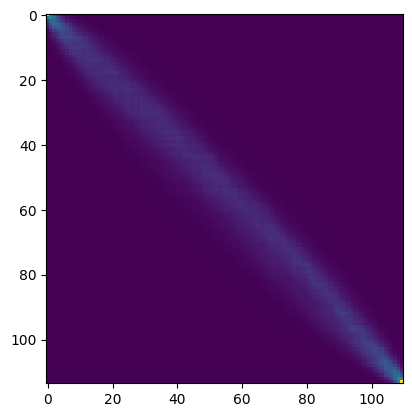

In [36]:
Loss, distribution_grad = calc_loss()

In [38]:
distribution_grad

array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -1.39449469e+01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -5.88936785e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -3.40606368e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -1.06691208e-62],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -3.16702620e-65],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00, -6.07601437e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e

In [39]:
Loss

593.1403755667734

In [40]:
# inject our custom grad
_loss = (distribution_tensor * Tensor(distribution_grad)).sum()
_loss.backward()

In [41]:
opt.params[0].numpy()

array([-0.32377362,  0.33334816,  0.23075509, ..., -0.09434712,
       -0.5492321 , -0.14436603], dtype=float32)

In [42]:
opt.params[-1].numpy()

array([[ 0.03621627, -0.03298142, -0.03953183, ...,  0.04186529,
        -0.02599826, -0.03571414],
       [-0.04230287,  0.041132  ,  0.03153536, ...,  0.01320496,
        -0.02308241, -0.02113631],
       [ 0.00609764,  0.01610614,  0.03805899, ..., -0.00025219,
        -0.00086646,  0.03515497],
       ...,
       [ 0.01325271,  0.02658705, -0.00545933, ...,  0.03629969,
        -0.01766927, -0.00227755],
       [-0.01319362, -0.01674412,  0.03830541, ..., -0.00648364,
        -0.0239429 ,  0.03425549],
       [-0.02731262,  0.02339033,  0.02767349, ..., -0.0327782 ,
         0.02033347,  0.02428198]], dtype=float32)

In [43]:
opt.step()

In [44]:
opt.params[-1].numpy()

array([[ 0.03721626, -0.03198143, -0.03853183, ...,  0.04286529,
        -0.02499826, -0.03471415],
       [-0.04330286,  0.040132  ,  0.03053537, ...,  0.01220497,
        -0.0240824 , -0.0221363 ],
       [ 0.00509765,  0.01510615,  0.03705899, ..., -0.00125218,
        -0.00186645,  0.03415498],
       ...,
       [ 0.0142527 ,  0.02758704, -0.00445934, ...,  0.03729968,
        -0.01666928, -0.00127756],
       [-0.01419361, -0.01774411,  0.03730541, ..., -0.00748363,
        -0.0249429 ,  0.03325549],
       [-0.02631262,  0.02439033,  0.02867348, ..., -0.03177821,
         0.02133347,  0.02528198]], dtype=float32)

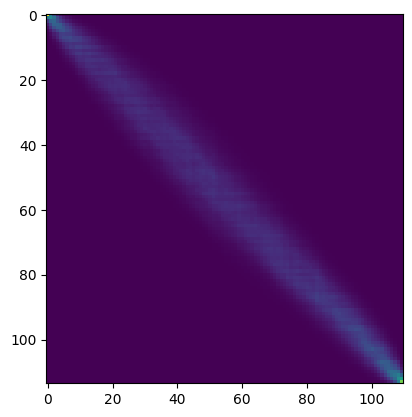

In [49]:
Loss,grad = calc_loss()

In [50]:
Loss

558.5214448410874